In [7]:
import os
import torchvision
import torch
from torchvision import datasets, transforms
from PIL import Image, UnidentifiedImageError
from torch.utils.data import DataLoader, random_split, Dataset
import warnings
from tqdm.auto import tqdm
from PIL import Image

# Suppress all warnings
warnings.filterwarnings("ignore")

DATA_PATH = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# Create a list call `data_paths` and store the absolute paths of each image
data_paths = []

# There are two images that are faulty and are not supported by PIL library. Hence I am ignoring them.
IGNORE_PATHS = [
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg',
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg'
]

classes = ['Dog', 'Cat']
for i in classes:
    for j in os.listdir(os.path.join(DATA_PATH, i)):
        path = os.path.join(DATA_PATH, i,j)
        if path.endswith(".jpg") and path not in IGNORE_PATHS:
            data_paths.append(path)
print("Total Number of images:", len(set(data_paths)))

Total Number of images: 24998


# Loading the Dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        img_path = self.data_path[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        label = 0 if "Dog" in img_path else 1
        return img, label
            
transformation_steps = transforms.Compose([
    transforms.Resize((370, 370)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

dataset = CustomDataset(data_path=data_paths, transform=transformation_steps)

# Preparing the data

In [10]:
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the split ratios
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the number of samples for each split
num_train = int(train_ratio * len(dataset))
num_test = len(dataset) - num_train

# Split the dataset
train_set, test_set = random_split(dataset, [num_train, num_test])

# Create data loaders
BATCH_SIZE = 64
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
print(f"Total Number of Images in Train: {len(train_dataloader) * BATCH_SIZE} | Test: {len(test_dataloader) * BATCH_SIZE} ")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total Number of Images per batch in Train: {len(train_dataloader)} | Test: {len(test_dataloader)} ")

Total Number of Images in Train: 20032 | Test: 5056 
Batch size: 64
Total Number of Images per batch in Train: 313 | Test: 79 


# Model Architecture

In [12]:
from torch import nn
import torchvision.models as models

vgg16_model = models.vgg16(pretrained=True)
vgg16_model = nn.Sequential(*list(vgg16_model.children())[:-1])

# Freeze the parameters of the pre-trained VGG16 layers
for param in vgg16_model.parameters():
    param.requires_grad = False
    
# Define the custom classifier
classifier = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(512 * 7 * 7, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2),
)
model = nn.Sequential(vgg16_model, classifier).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [ ]:
EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
    # Training
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        #---------------------------#
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        #---------------------------#
        y_pred_logits = model(X_train)
        loss = loss_fn(y_pred_logits, y_train)
        train_loss += loss.item()
        #---------------------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #---------------------------#
        y_pred = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        train_acc += (y_pred == y_train).sum().item() / len(y_train)
        #---------------------------#
    train_loss /= (batch + 1)
    train_acc /= (batch + 1)
    
    # Testing
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for test_batch, (X_test, y_test) in enumerate(test_dataloader):
            if (batch // BATCH_SIZE) % 100 == 0:
                print(f"\rEpoch: {epoch}/{EPOCHS} | Batch: {batch}/{total_dataset_size}", end="", flush=True)
            #---------------------------#
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            #---------------------------#
            test_pred_logits = model(X_test)
            loss = loss_fn(test_pred_logits, y_test)
            test_loss += loss.item()
            #---------------------------#
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels == y_test).sum().item() / len(y_test)
            #---------------------------#
        test_loss /= (test_batch + 1)
        test_acc /= (test_batch + 1)
    print(f" | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

# Predictions

Dog


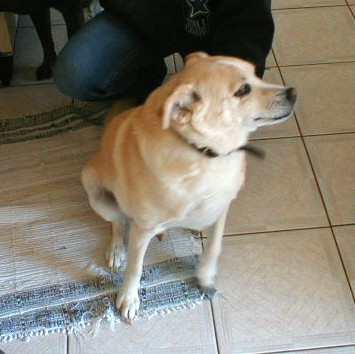

In [14]:
import random

classes = ['Dog','Cat']
random_path = random.choice(data_paths)

def get_prediction(random_path):
    random_raw_img, label = Image.open(random_path), 0 if "Dog" in random_path else 1
    random_img = transformation_steps(random_raw_img)
    outputs = model(random_img.to(device).unsqueeze(0))
    predicted = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
    label = classes[int(predicted.item())]
    return label

print(get_prediction(random_path))
Image.open(random_path)

# Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

all_true_labels = []
all_predicted_labels = []

# Iterate through the test dataset to get predictions
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

        all_true_labels.extend(labels.tolist())
        all_predicted_labels.extend(predicted.tolist())
# Convert lists to numpy arrays
true_labels_np = np.array(all_true_labels)
predicted_labels_np = np.array(all_predicted_labels)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels_np, predicted_labels_np)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title('Confusion Matrix')
plt.show()